In [178]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree    # Decision Tree
from sklearn.linear_model import LogisticRegression # LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC # Support Vector Machine 
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.feature_extraction.text as sk_text


## File Prep ##

In [179]:
%%time
column_names=['Name', 'ScreenName', 'UserID', 'FollowersCount', 'FriendsCount', 'Location', 'Description', 'CreatedAt', 'StatusID', 'Language', 'Place', 'RetweetCount', 'FavoriteCount', 'Text']
tweets = pd.read_csv('clinton_trump_tweets.txt', sep="\t",  encoding="ISO-8859-1", header=None, names=column_names)
#print initial data
tweets = tweets.drop(['ScreenName', 'FollowersCount', 'FriendsCount', 'CreatedAt', 'StatusID','Language', 'Place', 'RetweetCount', 'FavoriteCount'], axis=1)
tweets.Location = tweets.Location.astype(str)
tweets.Text = tweets.Text.astype(str)

ground_truth = pd.read_table('clinton_trump_user_classes.txt', encoding ="ISO-8859-1", dtype=int, names=["UserID", "TrumpOrClinton"])



CPU times: user 42.2 s, sys: 2.79 s, total: 45 s
Wall time: 46.3 s


### Task 1.1 (10 pts): Remove all retweets first. Remove all users that have less than 20 tweets. You may want to keep the entire tweet content, including hashtags/handles. ###

In [180]:
tweets = tweets[~tweets.Text.str.startswith('RT')]

In [176]:
%%time
def keepHashMentions(text):
    hashMentions = []
    for word in text:
        hashMentions.extend(word)
    return " ".join(hashMentions).strip()
## keeping tweet including hashtags and mentions here ## 
tweets['HashMentions'] = tweets.Text.str.findall('(@\w+)|(#\w+)').apply(keepHashMentions)


KeyboardInterrupt: 

### Remove all users that have less than 20 tweets. ###

In [181]:
#1.2 keep tweets where UID appears 20+ times
tweets = tweets.groupby("UserID").filter(lambda x: len(x) >= 20)

In [ ]:
%%timeit
# Generate a list of mention/hashes that have a frequency of 20+ #
top_hash = pd.Series(tweets['HashMentions'].str.cat(sep=' ').split()).value_counts()
top20 = top_hash[top_hash>=20]
top20List = top20.index.tolist()

# Convert list to set so it will have quick lookup
top20Set = set(top20List)


# generate list of mention/hashes that occur 20+ times from our orginal list 
def removeUnder20Mentions(hashMentions):
    mentions =  hashMentions.split()
    mentionsOver20 = []
    for mention in mentions:
        if(mention in top20Set):
            mentionsOver20.append(mention)
    return " ".join(mentionsOver20)
tweets['HashMentions'] = tweets.HashMentions.apply(removeUnder20Mentions)

## Create new df merging hashmentions and UserID  ##

In [182]:
hashMentionsMerged = tweets.groupby('UserID')['Text'].apply(' '.join).reset_index()
tweetsWithNoHashMentions = tweets.drop('Text', axis=1)
tweets = pd.merge(tweetsWithNoHashMentions, hashMentionsMerged, on='UserID')
tweets = tweets.drop_duplicates('UserID')


### #remove users that have no hashtag/handles ###

In [183]:
#tweets = tweets[tweets.Text.apply(lambda x:  bool(x and x.strip()))]
#print(tweets.shape)

In [184]:
##NEW
tweets['InputData'] =  tweets['Location']+" "+tweets['Description'] +" "+tweets['Text']
aggregateTweetsHashtags = tweets.groupby('UserID')['InputData'].apply(lambda x: x.str.cat(sep=' '))
tweetsPrepareSKText = pd.DataFrame({'User_id': aggregateTweetsHashtags.index, 'All_hashtags': aggregateTweetsHashtags.values})

vectorizerInput = sk_text.TfidfVectorizer(max_features = 50000,
                             #min_df=.1, 
                             #max_df=.8,
                             stop_words = ['UserID','10','100','11','12','14','15','16','17','18','19','2016']
                            )

                             
matrix = vectorizerInput.fit_transform(tweetsPrepareSKText.All_hashtags.values)
tdidf = matrix.toarray()
df_text = pd.DataFrame(matrix.todense(), index=aggregateTweetsHashtags.index, columns=vectorizerInput.get_feature_names())
df_text.head()
dataFrameWithHashTagHandlesAndTruths = pd.merge(df_text,ground_truth, on = 'UserID')


/Users/jashmit/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['userid'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [185]:
len(vectorizerInput.get_feature_names())

50000

In [9]:
# Remove locations that are null 
#tweets['LocationCleaned'] = tweets['Location'].apply(lambda x: x.split(',')[0])

tweetsLocations = tweets[tweets['Location'].notnull() & tweets['Description'].notnull() & tweets['HashMentions'].notnull()]

tweetsLocations = tweetsLocations[(tweetsLocations['Location'] != 'nan') & (tweetsLocations['Location'] != ' ') & (tweetsLocations['Location'] != '')]
print(tweets.shape)
tweets = tweetsLocations[tweetsLocations['Location'].isin(tweetsLocations['Location'].value_counts().nlargest(300).index.tolist())]
tweets['Location'] = tweetsLocations['Location'].map({'NYC':'New York City','New York':'New York City', 'NY':'New York City', 'SF':'San Francisco', 'Hollywood':'Los Angeles'}).fillna(tweetsLocations['Location'])

tweets['Location'].value_counts()

(21584, 6)


/Users/jashmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


New York City           279
United States           201
Washington, DC          181
New York, NY            179
Los Angeles, CA         177
USA                     171
London                  125
Los Angeles             119
Chicago, IL             102
Chicago                  94
Texas                    82
Boston, MA               81
San Francisco, CA        73
Brooklyn, NY             72
California               65
Florida                  61
Florida, USA             58
Seattle, WA              57
Austin, TX               56
San Francisco            54
Canada                   53
California, USA          52
Atlanta, GA              52
Portland, OR             51
Toronto                  49
Washington, D.C.         48
Houston, TX              47
New York, USA            45
Philadelphia, PA         45
Dallas, TX               45
                       ... 
Salt Lake City, Utah      6
Hong Kong                 6
Orlando                   6
Toronto, ON               6
Johannesburg        

In [10]:
aggregateTweetsHashtags = tweets.groupby('UserID')['HashMentions'].apply(lambda x: x.str.cat(sep=' '))
tweetsPrepareSKText = pd.DataFrame({'User_id': aggregateTweetsHashtags.index, 'All_hashtags': aggregateTweetsHashtags.values})
vectorizer = sk_text.TfidfVectorizer(max_features = 1000,
                             #min_df=100, 
                             #max_df=.8,
                             stop_words = ['UserID']
                             )
matrix = vectorizer.fit_transform(tweetsPrepareSKText.All_hashtags.values)
tdidf = matrix.toarray()
df_text = pd.DataFrame(matrix.todense(), index=aggregateTweetsHashtags.index, columns=vectorizer.get_feature_names())
df_text.head()

/Users/jashmit/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['userid'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,039,0hour1__,100ktweets4safety,1a,2a,4la_volpe,8217,8230,9appscom,_makada_,...,wsjdlive,wwe,wwiii,wyoming,yahoonews,yelp,yesursjewelry,youranonnews,youtube,yusufdfi
UserID,,,,,,,,,,,,,,,,,,,,,
2391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1026541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1054941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Vectorize Description ###

In [11]:
vectorizerDescription = sk_text.TfidfVectorizer(max_features = 500,
                             #min_df=100, 
                             #max_df=.8,
                             stop_words = ['UserID','10','100','11','12','14','15','16','17','18','19','2016']
                            )

matrixDescription = vectorizerDescription.fit_transform(tweets.Description.values)
tdidfDescription = matrixDescription.toarray()
df_text_Description = pd.DataFrame(matrixDescription.todense(), index=tweets.UserID, columns=vectorizerDescription.get_feature_names())
df_text_Description.head()

,2a,about,account,activist,actor,addict,advocate,aficionado,all,also,...,world,write,writer,writing,year,years,york,you,your,youtube
UserID,,,,,,,,,,,,,,,,,,,,,
106568768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2447279666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201499452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17547533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2263109930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Vectorize Description ###

In [12]:
vectorizerLocation = sk_text.TfidfVectorizer(#max_features = 1000,
                             #min_df=100, 
                             #max_df=.8,
                             stop_words = ['UserID']                
                            )
matrixLocation = vectorizerLocation.fit_transform(tweets.Location.values)
tdidfLocation = matrixDescription.toarray()
df_text_Location = pd.DataFrame(matrixLocation.todense(), index=tweets.UserID, columns=vectorizerLocation.get_feature_names())
df_text_Location.head()



,africa,al,alabama,alberta,albuquerque,alexandria,alto,america,angeles,ann,...,wales,washington,wi,wichita,wisconsin,worldwide,worth,wv,york,zealand
UserID,,,,,,,,,,,,,,,,,,,,,
106568768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2447279666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
201499452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.565174,0.0
17547533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2263109930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## Apply ground truths column to UserID of tweets Dataframe ##

In [13]:
#mergeGroundTruths = pd.merge(tweets, ground_truth, on = 'UserID')
#ground truth
dataFrameWithHashTagHandlesAndTruths = pd.merge(df_text,ground_truth, on = 'UserID')


##merge Description and Location into out dataframe 
dataFrameWithHashTagHandlesAndTruths = pd.merge(dataFrameWithHashTagHandlesAndTruths,df_text_Description,on = 'UserID')

dataFrameWithHashTagHandlesAndTruths = pd.merge(dataFrameWithHashTagHandlesAndTruths,df_text_Location,on = 'UserID')

## Implementing Logistic Regression on Location column, rest of models are below ##

### 1.1: Use train_test_split() to split data into training and test sets, where 20 percent of the records go to test set. ###

In [186]:
X = dataFrameWithHashTagHandlesAndTruths.drop(['UserID','TrumpOrClinton'], axis=1)
# grabbing one of the location arrays: USA
y = dataFrameWithHashTagHandlesAndTruths.TrumpOrClinton.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Task 1.2 (20 pts): Train Decision Tree, SVM, Logistic Regression, and Neural Networks #

## Decision Tree ##

In [ ]:
## Decision tree boilerplate
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.precision_score(y_test, y_pred, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred))

0.6330466186664042
0.6292593348296266
0.6298741602398691
[[1452  798]
 [1019 1632]]


## SVM ##

In [ ]:
clf = SVC(C=1.0, gamma='auto') 
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

print(metrics.precision_score(y_test, y_pred, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred))

## LogisticRegression ##

In [167]:
logreg = LogisticRegression(solver='lbfgs') 
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


print(metrics.precision_score(y_test, y_pred, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred))

0.7638392033929559
0.7543103448275862
0.7314725490430765
[[180 240]
 [ 45 695]]


In [170]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Nueral Networks ##

In [171]:
mlp = MLPClassifier(hidden_layer_sizes=(1000,1000,1000), solver='adam', max_iter=1000)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))


              precision    recall  f1-score   support

           0       0.61      0.61      0.61       420
           1       0.78      0.78      0.78       740

   micro avg       0.71      0.71      0.71      1160
   macro avg       0.69      0.69      0.69      1160
weighted avg       0.71      0.71      0.71      1160

0.71480260740679
0.7146551724137931
0.7147283531067926
[[255 165]
 [166 574]]


# Task 1.3 (20 pts): Train k-NN model. In your report describe the features that you used for k-NN. Perform parameter tuning on k-NN model. Apply 5-fold cross validation and use grid search to find the best K value for k-NN model. Set scoring metric to F1 score (F-measure). Use the best K value identified from grid search to train your k-NN model. Plot the F1 score against K value based on the results you achieved from grid search. #

In [21]:
%%time
param_grid = dict(n_neighbors=range(1,21))
knn = KNeighborsClassifier(n_neighbors=1)
grid = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted',n_jobs=2)
grid.fit(X_train, y_train)
# view the complete results
means = grid.cv_results_['mean_test_score']

CPU times: user 736 ms, sys: 172 ms, total: 909 ms
Wall time: 18min 23s


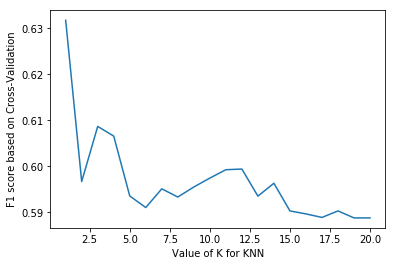

In [28]:
import matplotlib.pyplot as plt
# plot the results
plt.plot(range(1,21),means)
plt.xlabel('Value of K for KNN')
plt.ylabel('F1 score based on Cross-Validation')
plt.show()

In [23]:
# identify the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6317280598132794
{'n_neighbors': 1}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')


In [33]:
%%time
# train your model using all data and the best known parameters
#TODO: use best n_neighbors from grid search
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn.fit(X_train, y_train)
y_pred =  knn.predict(X_test)

print(metrics.precision_score(y_test, y_pred, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred))

0.6360894343847597
0.65375
0.6431158272517812
[[ 80 160]
 [117 443]]
CPU times: user 5.99 s, sys: 54.6 ms, total: 6.04 s
Wall time: 6.31 s


In [172]:
X.shape

(5798, 8941)